# ⚡ Battery Energy Storage System (BESS) Analysis

## Project Overview  
This project focuses on the **performance analysis of a Battery Energy Storage System (BESS)** — a critical component in modern smart grids and renewable energy integration.  

The notebook explores how energy is:  
- **Generated** from renewable or distributed sources  
- **Consumed** by connected loads  
- **Stored** in the battery for later use  
- **Exported** back to the grid when production exceeds demand  

By leveraging **data analytics and visualization**, this project provides insights into the **energy flow dynamics**, system efficiency, and the **optimal utilization** of storage capacity.  

---

## 🎯 Objectives  
- Evaluate the **charging and discharging behavior** of the battery system  
- Quantify the **energy and power exchanged** between the grid, storage, and local consumption  
- Identify **patterns or inefficiencies** in system performance  
- Support **decision-making** for improving renewable energy integration and grid stability  

---

## 🧠 Key Features  
- Detailed energy flow and balance analysis  
- Time-series visualization of grid, battery, and load data  
- Computation of energy metrics such as charging efficiency and grid export ratios  
- Flexible framework for analyzing different datasets or operating conditions  

---

In [1]:
# 📦 Import Required Libraries
# NumPy and Pandas for data handling, Seaborn/Matplotlib for visualization,
# SciPy for interpolation and integration functions.
#importing the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 📂 Load CSV Data
# The  CSV files contain solar generation and power consumption values.
# Each CSV is expected to include timestamped readings.
#extracting data from csv file and deleting the irrelevent column

df = pd.read_csv('dataset.csv')
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df['generation'] = df['generation']*.001
df['consumption'] = df['consumption']*.001 
    #converting the W values into KW
df.head()

,timestamp,generation,consumption
0,00:00,0.0,5.562083
1,00:01,0.0,4.913722
2,00:02,0.0,4.316400
3,00:03,0.0,3.768393
4,00:04,0.0,3.267981


In [4]:
"""
⚡ Battery Energy Storage System (BESS) Simulation Module

This module defines a `BatterySystem` class to simulate the operation of a
battery energy storage system (BESS) interacting with solar generation,
load (consumption), and grid power.

It models:
- Energy flow between solar, load, battery, and grid.
- Battery charge/discharge behavior based on power balance.
- Energy and billing analytics.
- Visualization utilities (bar, pie, and custom time-based plots).
"""

class BatterySystem:
    """
    Class representing a Battery Energy Storage System (BESS).
    
    Attributes:
        battery_capacity (float): Total capacity of the battery in kWh.
        dt (float): Time step in hours (e.g., 1/60 for minute-wise data).
        battery_soc (float): Current State of Charge (SOC) of the battery (%).
    """

    def __init__(self, battery_capacity=13.500, dt=1/60, initial_soc=50):
        """
        Initialize the battery system parameters.
        
        Args:
            battery_capacity (float): Battery capacity in kWh (default: 13.5 kWh).
            dt (float): Time step in hours (default: 1 minute = 1/60 h).
            initial_soc (float): Initial battery SOC (%) (default: 50%).
        """
        self.battery_capacity = battery_capacity
        self.dt = dt
        self.battery_soc = initial_soc

    # -------------------------------------------------------------------------
    # Core Simulation Logic
    # -------------------------------------------------------------------------
    def step(self, generation, consumption):
        """
        Simulate one time-step of energy flow between solar, load, battery, and grid.
        
        Args:
            generation (float): Solar PV generation in kW.
            consumption (float): Load consumption in kW.
        
        Returns:
            tuple: (grid power, battery power, battery SOC)
            
            - grid (float): Positive when exporting to grid, negative when importing.
            - battery (float): Positive when charging, negative when discharging.
            - battery_soc (float): Updated SOC (%) after this step.
        """
        grid = 0.0
        battery = 0.0

        # Case 1: Load is higher than generation → Discharge battery or import from grid
        if generation < consumption:
            demand = consumption - generation
            demand_energy = demand * self.dt  # energy required from other sources (kWh)

            # If battery has charge available
            if self.battery_soc > 0:
                available_energy = (self.battery_soc / 100) * self.battery_capacity

                # Battery can fully supply the deficit
                if demand_energy <= available_energy:
                    self.battery_soc -= (demand_energy / self.battery_capacity) * 100
                    battery = -demand
                # Battery partially supplies, rest from grid
                else:
                    battery_power = -(available_energy / self.dt)
                    grid_power = -(demand - available_energy / self.dt)
                    battery = battery_power
                    grid = grid_power
                    self.battery_soc = 0
            else:
                # Battery empty → import full demand from grid
                grid = -demand

        # Case 2: Generation is higher than load → Charge battery or export to grid
        elif generation > consumption:
            supply = generation - consumption
            free_energy = supply * self.dt

            # If battery not full, charge it
            if self.battery_soc < 100:
                remaining_capacity = self.battery_capacity - (self.battery_soc / 100) * self.battery_capacity

                if free_energy <= remaining_capacity:
                    self.battery_soc += (free_energy / self.battery_capacity) * 100
                    battery = supply
                else:
                    battery_power = remaining_capacity / self.dt
                    grid_power = (free_energy - remaining_capacity) / self.dt
                    battery = battery_power
                    grid = grid_power
                    self.battery_soc = 100
            else:
                # Battery full → export surplus to grid
                grid = supply

        # Keep SOC within valid physical limits [0, 100]
        self.battery_soc = max(0, min(100, self.battery_soc))

        return grid, battery, self.battery_soc

    # -------------------------------------------------------------------------
    # Energy Analysis Methods
    # -------------------------------------------------------------------------
    def energy(self, df):
        """
        Compute total energy (kWh) for various components using trapezoidal integration.

        Args:
            df (DataFrame): Time-series data containing 'generation', 'consumption',
                            'grid import', 'grid export', 'battery charge', 'battery discharge'.

        Returns:
            dict: Summary of energy (kWh) for each category.
        """
        generation_energy = np.trapezoid(df['generation'], dx=self.dt)
        consumption_energy = np.trapezoid(df['consumption'], dx=self.dt)
        grid_import_energy = np.trapezoid(df['grid import'].abs(), dx=self.dt)
        grid_export_energy = np.trapezoid(df['grid export'], dx=self.dt)
        charge_energy = np.trapezoid(df['battery charge'], dx=self.dt)
        discharge_energy = np.trapezoid(df['battery discharge'], dx=self.dt)
        
        return {
            "generation (kWh)": generation_energy,
            "consumption (kWh)": consumption_energy,
            "grid_import (kWh)": grid_import_energy,
            "grid_export (kWh)": grid_export_energy,
            "charge_energy (kWh)": charge_energy,
            "discharge_energy (kWh)": discharge_energy
        }

    # -------------------------------------------------------------------------
    # Billing Computation
    # -------------------------------------------------------------------------
    def billing(self, df):
        """
        Estimate electricity bill with and without the BESS system.
        
        Assumptions:
            - Import tariff: ₹10/kWh
            - Export rate: ₹6/kWh (feed-in tariff)
        
        Args:
            df (DataFrame): Simulation data with energy flow.
        
        Returns:
            dict: Billing summary with profit/loss analysis.
        """
        energies = self.energy(df)
    
        bill_wo_bess = energies["consumption (kWh)"] * 10
        bill_w_bess = energies["grid_import (kWh)"] * 10
        profit = energies["grid_export (kWh)"] * 6 
    
        net_balance = profit - bill_w_bess

        # Determine whether user earns or pays
        if net_balance >= 0:
            profit_earned = net_balance
            to_be_paid = 0.0
        else:
            profit_earned = 0.0
            to_be_paid = -net_balance
    
        return {
            "bill without battery": f"Rs {bill_wo_bess:.2f}",
            "bill with battery": f"Rs {bill_w_bess:.2f}",
            "profit due to export": f"Rs {profit:.2f}",
            "total due": f"Rs {to_be_paid:.2f}",
            "total profit": f"Rs {profit_earned:.2f}"
        }

    # -------------------------------------------------------------------------
    # Visualization Utilities
    # -------------------------------------------------------------------------
    def custom(self, df):
        """
        Display power flow at a specific timestamp as a bar chart.
        
        Args:
            df (DataFrame): Simulation results with 'timestamp', 'generation',
                            'consumption', 'battery', and 'grid' columns.
        """
        time = input("Enter time (HH:MM): ")
    
        if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
            df["timestamp"] = pd.to_datetime(df["timestamp"])
    
        row = df[df["timestamp"].dt.strftime("%H:%M") == time]
    
        if row.empty:
            print("No data found for the given time.")
            return None
    
        row = row.iloc[0]
    
        labels = ["Generation", "Consumption", "Battery", "Grid"]
        values = [row["generation"], row["consumption"], row["battery"], row["grid"]]
        colors = ["palegoldenrod", 'cornflowerblue', "tan", "darksalmon"]
    
        plt.figure(figsize=(6,4))
        plt.bar(labels, values, color=colors)
        plt.title(f"System Status at {time}")
        plt.ylabel("Power (kW)")
        plt.axhline(0, color="black", linewidth=0.8)
        plt.show()
    
        return row

    def pie_plot(self, df):
        """
        Plot a pie chart showing the contribution of Solar, Battery, and Grid
        to total load consumption.
        """
        df["solar_to_load"] = np.minimum(df["generation"], df["consumption"])
        battery_to_load = np.trapezoid(df["battery"].where(df["battery"] < 0, 0).abs(), dx=self.dt)
        grid_to_load = np.trapezoid(df["grid import"].abs(), dx=self.dt)
        solar_to_load = np.trapezoid(df["solar_to_load"], dx=self.dt)
    
        labels = ["Solar", "Battery", "Grid"]
        values = [solar_to_load, battery_to_load, grid_to_load]
        colors = ["palegoldenrod", "tan", "darksalmon"]
    
        total = sum(values)
    
        def autopct_func(pct):
            absolute = pct * total / 100
            return f"{pct:.1f}%\n({absolute:.1f} kWh)"
    
        plt.figure(figsize=(6,6))
        plt.pie(values, labels=labels, autopct=autopct_func, startangle=90, colors=colors, textprops={"fontsize": 11})
        plt.title("Share of Consumption Supplied by Solar, Battery, and Grid", fontsize=13)
        plt.tight_layout()
        plt.show()
    
        print("Energy supplied:")
        for label, val in zip(labels, values):
            print(f"{label}: {val:.2f} kWh ({val/total*100:.1f}%)")

    def bar_plot(self, df):
        """
        Create a multi-panel bar plot for key system metrics over time:
        - Generation
        - Consumption
        - Grid Power
        - Battery Power
        - Battery SOC
        - Battery Energy (kWh)
        """
        # Compute stored energy (kWh) if not already present
        if "battery_energy" not in df.columns:
            df["battery_energy"] = df["battery_soc"] * self.battery_capacity / 100
    
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
        
        plots_to_make = [
            ('generation', 'Solar Generation (kW)', 'goldenrod', axes[0,0]),
            ('consumption', 'House Load (kW)', 'cornflowerblue', axes[0,1]),
            ('grid', 'Grid Power (kW)', 'darksalmon', axes[0,2]),
            ('battery', 'Battery Power (kW)', 'tan', axes[1,0]),
            ('battery_soc', 'Battery-State of Charge (%)', 'mediumseagreen', axes[1,1]),
            ('battery_energy', 'Battery Stored Energy (kWh)', '#17BECF', axes[1,2])
        ]
        
        # Plot each parameter
        for y_col, title, color, ax in plots_to_make:
            sns.barplot(x='timestamp', y=y_col, data=df, color=color, ax=ax, linewidth=1.2)
            ax.set_title(title, fontsize=13, fontweight="bold")
            ax.set_ylabel("")
            ax.grid(True, linestyle="--", alpha=0.5)
        
        # Improve X-axis readability
        for ax in axes.flat:
            xticks = ax.get_xticks()
            if len(xticks) > 0:
                ax.set_xticks(xticks[::max(1, len(xticks)//12)])  # show ~6 labels
                ax.tick_params(axis='x', rotation=90, labelsize=8)
            ax.set_xlabel("Timestamp", fontsize=9)
        
        plt.tight_layout()
        plt.show()


In [5]:
# -----------------------------------------------------------------------------
# Initialize output columns in the dataframe
# -----------------------------------------------------------------------------
# These columns will be filled during simulation with computed values.
df['battery'] = 0.0        # Battery power at each time step (kW)
df['battery_soc'] = 0.0    # Battery state of charge (%) at each time step

# -----------------------------------------------------------------------------
# Initialize the BatterySystem object
# -----------------------------------------------------------------------------
# battery_capacity = 13.5 kWh (typical for home storage)
# dt = 1/60 hours (1-minute time step)
# initial_soc = 27% (starting battery charge)
system = BatterySystem(battery_capacity=13.500, dt=1/60, initial_soc=27)

# -----------------------------------------------------------------------------
# Run BESS Simulation
# -----------------------------------------------------------------------------
# Iterate over each time step in the dataframe to compute:
# - Grid interaction (import/export)
# - Battery charge/discharge
# - Updated SOC for each interval
for index, row in df.iterrows():
    # Call the step() function to simulate one timestep
    grid, battery, soc = system.step(row['generation'], row['consumption'])

    # Store computed results back into the DataFrame
    df.loc[index, 'grid'] = grid
    df.loc[index, 'battery'] = battery
    df.loc[index, 'battery_soc'] = soc

# -----------------------------------------------------------------------------
# Post-Processing: Split flows into charge/discharge & import/export
# -----------------------------------------------------------------------------
# Positive and negative power flows are separated for analysis and plotting.

# Grid import: when grid power is negative (importing from grid)
df["grid import"] = df["grid"].where(df["grid"] < 0, 0)

# Grid export: when grid power is positive (exporting to grid)
df["grid export"] = df["grid"].where(df["grid"] > 0, 0)

# Battery discharge: when battery supplies power (negative values)
df["battery discharge"] = df["battery"].where(df["battery"] < 0, 0)

# Battery charge: when battery is charging (positive values)
df["battery charge"] = df["battery"].where(df["battery"] > 0, 0)

In [6]:
# -----------------------------------------------------------------------------
# Compute Total Energy Summary (kWh)
# -----------------------------------------------------------------------------
# Uses trapezoidal numerical integration to calculate total energy exchanged 
# between all system components over the simulation period.
summary = system.energy(df)

# Display computed energy metrics (generation, consumption, grid, battery)
print("=== ENERGY SUMMARY (kWh) ===")
for key, val in summary.items():
    print(f"{key}: {val:.2f}")

=== ENERGY SUMMARY (kWh) ===
generation (kWh): 73.53
consumption (kWh): 68.27
grid_import (kWh): 4.12
grid_export (kWh): 11.87
charge_energy (kWh): 15.37
discharge_energy (kWh): -17.87


In [7]:
# -----------------------------------------------------------------------------
# Compute Billing Analysis
# -----------------------------------------------------------------------------
# Estimates electricity bill with and without the battery system.
# - Import rate: ₹10 per kWh
# - Export (feed-in) rate: ₹6 per kWh
bills = system.billing(df)

# Display detailed billing summary
print("\n=== BILLING SUMMARY ===")
for key, val in bills.items():
    print(f"{key}: {val}")


=== BILLING SUMMARY ===
bill without battery: Rs 682.72
bill with battery: Rs 41.15
profit due to export: Rs 71.23
total due: Rs 0.00
total profit: Rs 30.07


Enter time (HH:MM):  08:23


/var/folders/vw/5p5h0xbx48b8d1m6rrxns7cm0000gn/T/ipykernel_6933/3310522104.py:195: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"])


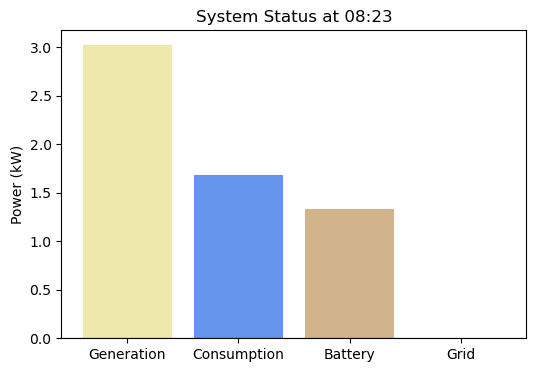

In [8]:
# 1️⃣ View system status at a specific time (e.g., 14:30)
time = system.custom(df)

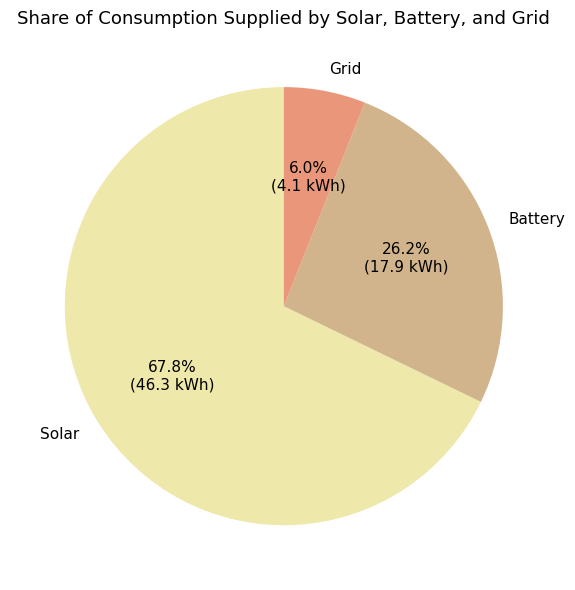

Energy supplied:
Solar: 46.29 kWh (67.8%)
Battery: 17.87 kWh (26.2%)
Grid: 4.12 kWh (6.0%)


In [9]:
# 2️⃣ View energy source contribution pie chart
pie = system.pie_plot(df)

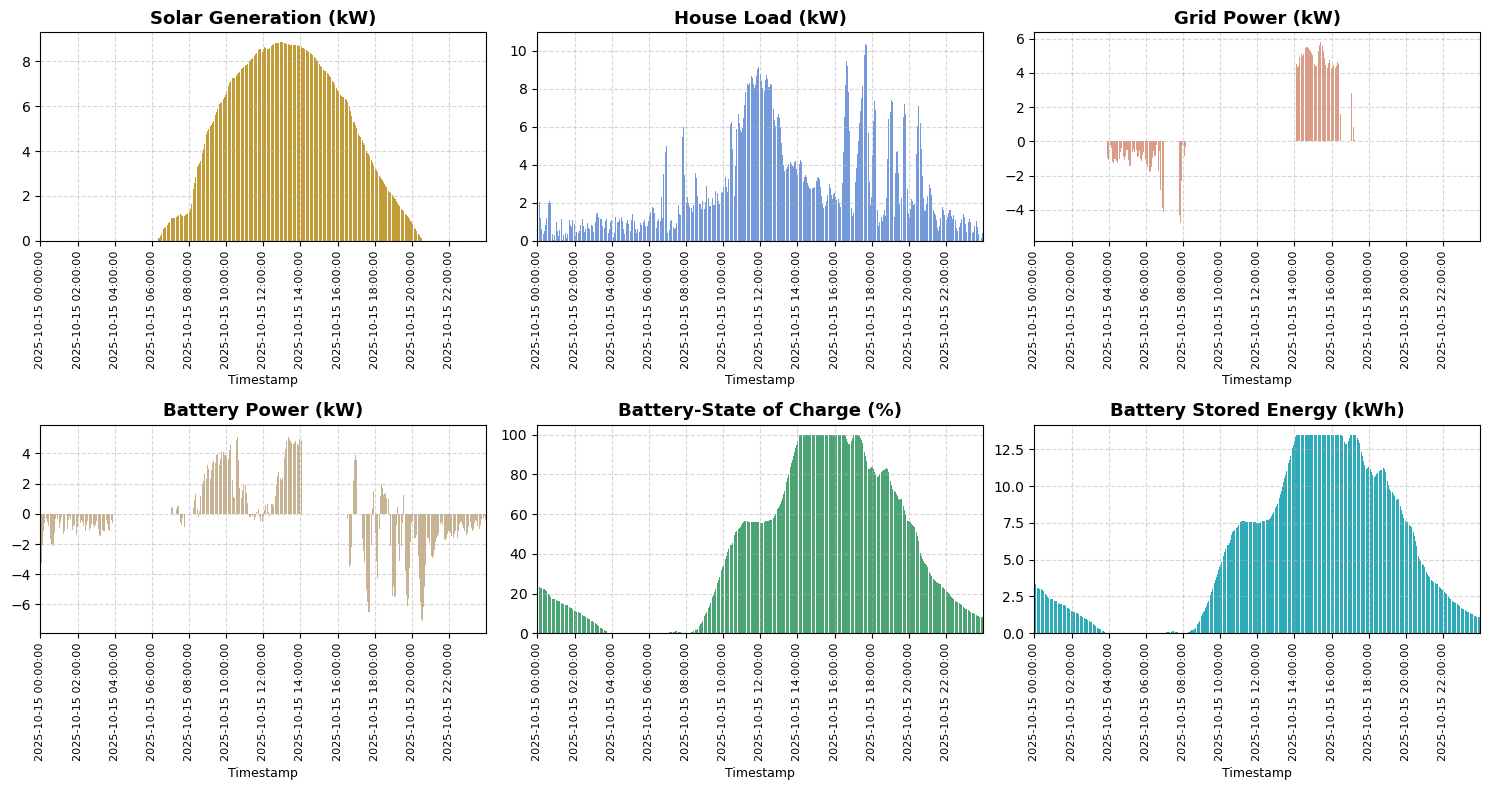

In [10]:
# 3️⃣ View bar plots for generation, load, grid, battery, and SOC
bar = system.bar_plot(df)

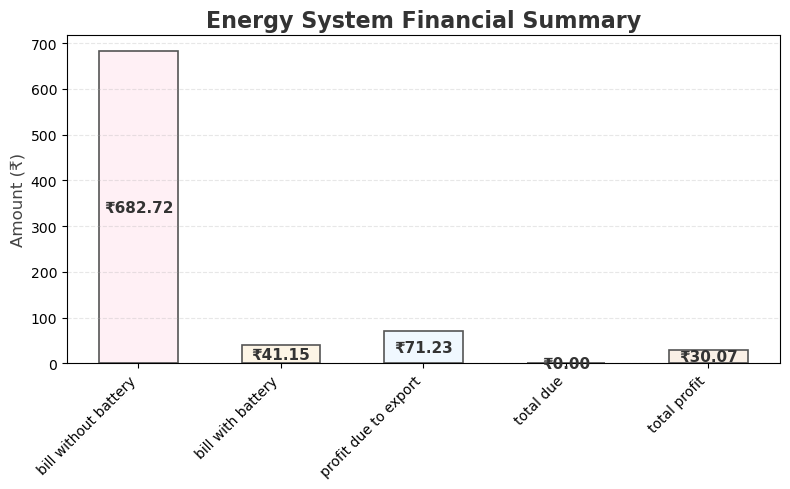

In [11]:
# 📊 Optional Visualization
# Use this section to preview or validate the processed data.
labels = list(bills.keys())
values = [float(bills[key][3:]) for key in bills.keys()]

# Use soft pastel colors (5 total)
colors = ["lavenderblush", "oldlace", "#f0f8ff", "#fff0f5", "#faf0e6"]

plt.figure(figsize=(8, 5), facecolor="white")
bars = plt.bar(labels, values, color=colors, width=0.55, edgecolor="#555", linewidth=1.2)

# Title and axis labels
plt.title("Energy System Financial Summary", fontsize=16, fontweight="bold", color="#333")
plt.ylabel("Amount (₹)", fontsize=12, color="#444")

# Rotate labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add values inside bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,  # middle of each bar
        f"₹{height:,.2f}",
        ha="center",
        va="center",
        fontsize=11,
        fontweight="bold",
        color="#333"
    )

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()
